# 세그멘테이션 모델 만들기
## Semantic Segmentation
* `U-Net`

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:   # 훈련용 데이터일 경우
        return Compose([
            HorizontalFlip(p=0.5),   # 50 % 확률로 좌우대칭
            RandomSizedCrop(   # 50 % 확률로 randomsizedcrop
                min_max_height=(300, 370),
                w2h_ratio=370/1242,
                height=224,
                width=224,
                p=0.5
            ),
            Resize(    # 입력 이미지를 224x224로 resize
                width=224,
                height=224,
            )
        ])
    return Compose([   # 테스트용 데이터의 경우 resize만 수행
        Resize(
            width=224,
            height=224
        )
    ])

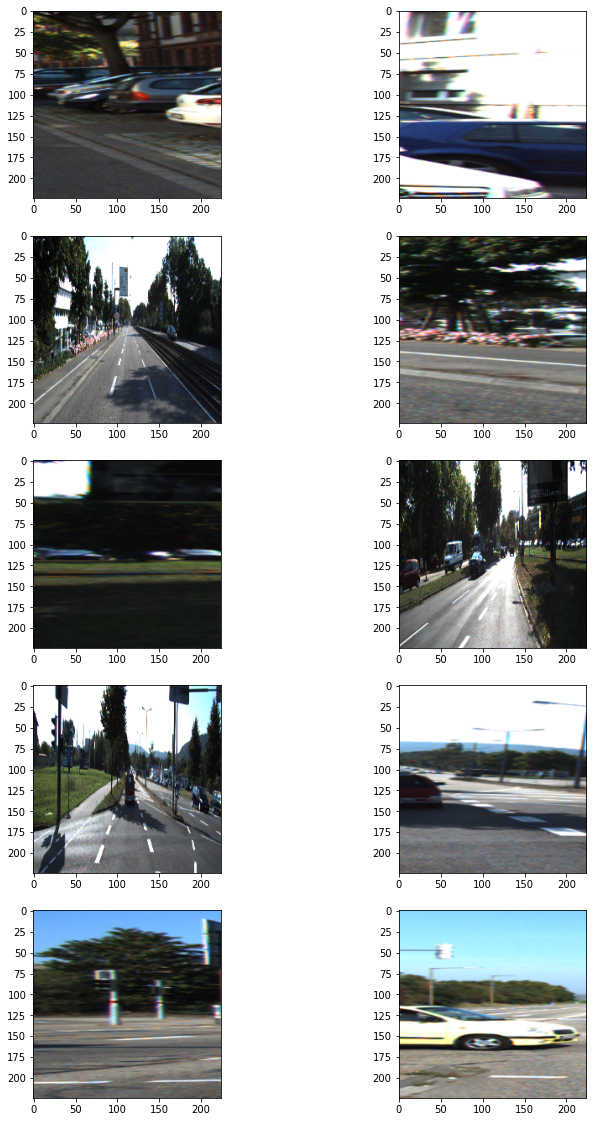

In [3]:
import os

dir_path = os.getenv("HOME") + '/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, 'image_2', '*.png'))

# 훈련 데이터셋에서 샘플 5개만 가져와보자
plt.figure(figsize=(12,20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {'image':image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized['image'])    # 왼쪽에 원본 이미지 표시
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed['image'])   # 오른쪽에 augmented image
    
plt.show()

In [5]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다
    우리가 KittiDataset을 원하는 방식대로 preprocess하기 위해서 Sequence를 커스텀해 사용합니다.
    '''
    def __init__(self,
                 dir_path,
                 batch_size=16,
                 img_size=(224, 224, 3),
                 output_size=(224, 244),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size
        img_size: preprocess에 사용할 입력 이미지의 크기
        output_size: ground_truth기의 크기에 맞추어 설정
        is_train: generator가 학습용인지 테스트용인지 표시
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        
        # load_dataset()을 통해서 kitti dataset 의 directory path 에서 라벨과 이미지를 확인
        self.data = self.load_dataset()
        
    def load_dataset(self):
        # kitti dataset 에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수
        # is_train 에 따라 test set 을 분리해서 load
        input_images = glob(os.path.join(self.dir_path, 'image_2', '*.png'))
        label_images = glob(os.path.join(self.dir_path, 'semantic', '*.png'))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]
        
        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length 로서 dataset 을 batch_size 로 나누고 소숫점 첛째자리에서 올림
        return math.ceil(len(self.data) / self.batch_size)
    
    def __getitem__(self, index):
        # 입력은 resize 및 augmentation이 적용된 input image
        # 출력은 semantic label 입니다.
        batch_data = self.data[
            index*self.batch_size:
            (index + 1)*self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_size):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                'image': _input,
                'mask': _output
            }
            
            augmented = self.augmentation(**data)
            inputs[i] = augmented['image']/255
            outputs[i] = augmented['mask']
            return inputs, outputs
        
    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행, 학습중인 경우에 순서를 random shuffle 하도록 적용
        self.indexes = np.arange(self.indexes)
        if self.is_train == True:
            np.random_shuffle(self.indexes)
            return self.indexes

In [6]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(
    dir_path,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path,
    augmentation=test_preproc,
    is_train=False
)

## 모델 구조 만들기

In [ ]:
def build_model(input_shape=(224,224,3)):
    model = None
    